In [2]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from scipy.stats import chi2
import numpy as np

# Plot data using Plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# For forest plot
import forestplot as fp


In [37]:
def extract_elof_genes(row, pli: float, oe_lof_upper: float, phaplo: float):
    if (row['pLI'] >= pli
            and row['oe_lof_upper'] < oe_lof_upper
            and row['pHaplo'] >= phaplo):
        return True
    else:
        return False 

def extract_g2pLoF_genes(x):
    if 'absent gene product' in x:
        return 'PASS'
    else:
        return '.'

def extract_definitive(x):
    if x == 'definitive':
        return 'PASS'
    else:
        return '.'

def extract_strong(x):
    if (x == 'definitive' or x == 'strong'):
        return 'PASS'
    else:
        return '.'

def extract_moderate(x):
    if (x == 'definitive' or x == 'strong' or x == 'moderate'):
        return 'PASS'
    else:
        return '.'
        
def create_gene_list(
        ajhg: pd.DataFrame, alldf: pd.DataFrame,
        higene: pd.DataFrame, gnomad: pd.DataFrame,
        set_name: str, pli: float, oe_lof_upper: float, 
        phaplo: float, dcpr_definitive: str, 
        ) -> set:
    
    # AJHG genes 
    ajhg_genes = set(ajhg['gene'])

    # HI genes
    hi_genes = set(higene.loc[higene['HIscore'] == 3, 'gene'])
    
    # Extract G2P genes
    alldf_filterd = alldf[alldf[f"{dcpr_definitive}FILTER"] == 'PASS']
    dcpr_genes = set(alldf_filterd['gene'])
    
    # Filteration of pLI, oe_lof_upper and pHaplo score
    gnomad['is_eLoF'] = gnomad.apply(
        extract_elof_genes, args=(pli, oe_lof_upper, phaplo), axis=1)
    gnomad_genes = set(gnomad.loc[gnomad['is_eLoF'] == True, 'gene'])

    # Union of all eLoF genes
    gene_set: set = (gnomad_genes).union(dcpr_genes).union(hi_genes).union(ajhg_genes)
    
    # Count
    print(f"{set_name} AJHG:DCPR:HI:pHaplo:Total - {len(ajhg_genes)} {len(dcpr_genes)} {len(hi_genes)} {len(gnomad_genes)} {len(gene_set)}")
    

    return set_name, gene_set

def calc_odds_ratio(
        group: str, label: str,
        a: int, b: int, c: int, d: int, z: float) -> tuple:
    
    odds_ratio = (a * d) / (b * c)
    log_odds = np.log(odds_ratio)
    se = np.sqrt(1/a + 1/b + 1/c + 1/d)
    logci: tuple = log_odds - z * se, log_odds + z * se

    # Example of a contingency table for the odds ratio calculation
    # |-----------|----------|----------|
    # |           | Positive | Negative |
    # |-----------|----------|----------|
    # | eLoF      | a        | b        |
    # | Not eLoF  | c        | d        |
    # |-----------|----------|----------|
    # z = 1.96 for 95% CI z: float
    # z = 2.58 for 99% CI
    # ci: tuple = np.exp(log_odds - z * se), np.exp(log_odds + z * se)

    # Chi2 test
    chi2, p = chi2_contingency([[a, b], [c, d]])[:2]

    # result_logor = '{:.2f}'.format(log_odds)
    # result_ci_lower = '{:.3f}'.format(logci[0])
    # result_ci_upper = '{:.3f}'.format(logci[1])

    return ['{:.3f}'.format(log_odds), '{:.3f}'.format(logci[0]), '{:.3f}'.format(logci[1]), p, group, label]

In [38]:
### Lodading canonical transcripts
canonlist = '../01_CanonicalTranscripts/CanonicalTranscripts.exoncount.tsv'
canon = pd.read_table(canonlist, sep='\t', header=0)
canon_set = set(canon['ENST'])

# Curation data
ajhg_path = 'AJHG_ClinGenLoF_genes.txt.gz'
hi_path = 'ClinGen_haploinsufficiency_gene_GRCh37.bed'
gnomad_path = 'gnomad.v2.1.1.lof_metrics.by_gene.txt.gz'
phaplo_path = 'Collins_rCNV_2022.dosage_sensitivity_scores.tsv.gz'

# G2P data
dd = './DDG2P.csv.gz'
eye = './EyeG2P.csv.gz'
skin = './SkinG2P.csv.gz'
cancer = './CancerG2P.csv.gz'
cardiac = './CardiacG2P.csv.gz'
skeletal = './SkeletalG2P.csv.gz'

# Validation set
am_path = 'AlphaMissense_gene_hg19.tsv.gz'
am_path = 'AlphaMissense_gene_level_list.txt'
genovo_path = 'GenovoLOEUF.txt.gz'
gnocchi_path = 'EnhancerGnocchi.txt.gz'

# Load data
ajhg = pd.read_csv(
    ajhg_path, sep='\t', header=None, skiprows=1,
    names=['gene', 'pLI', 'RefSeq', 'SpliceAcceptor', 'SpliceDonor'],
    usecols=['gene', 'RefSeq']) 

higene = pd.read_csv(
    hi_path, sep='\t', header=None, skiprows=1,
    names=['CHROM', 'start', 'end', 'gene', 'HIscore'],
    usecols=['gene', 'HIscore']
    ) 

gnomad = pd.read_csv(
    gnomad_path, sep='\t', compression='gzip',
    usecols=['gene', 'pLI', 'oe_lof_upper', 'transcript', 'cds_length']
    )

gnomad['is_canon'] = gnomad['transcript'].apply(
    lambda x: True if x in canon_set else False)

phaplo = pd.read_csv(
    phaplo_path, sep='\t', header=None, compression='gzip', skiprows=1,
    names=['gene', 'pHaplo', 'pTriplo'],
    usecols=['gene', 'pHaplo']
    ) 

# Merge gnomad and phaplo
gnomad = pd.merge(gnomad, phaplo, how='left',
                  left_on='gene', right_on='gene')

#### Extract non-canonical ENST and shorter cds transcript from duplicated genes
gnomad = gnomad.loc[(gnomad['transcript'] != 'ENST00000368073')] 
gnomad = gnomad.loc[(gnomad['transcript'] != 'ENST00000608209')] 


#### Create a set of union of ajhg , higene and gnomad genes
all_genes_set: set = set(ajhg['gene']).union(set(higene['gene'])).union(set(gnomad['gene']))
all_genes: pd.DataFrame = pd.DataFrame(all_genes_set, columns=['gene'])


#### G2P data 
dddf = pd.read_csv(dd, sep=',', header=0, compression='infer')
eyedf = pd.read_csv(eye, sep=',', header=0, compression='infer')
skidf = pd.read_csv(skin, sep=',', header=0, compression='infer')
candf = pd.read_csv(cancer, sep=',', header=0, compression='infer')
cardf = pd.read_csv(cardiac, sep=',', header=0, compression='infer')
skedf = pd.read_csv(skeletal, sep=',', header=0, compression='infer')
dfs = [dddf, eyedf, skidf, candf, cardf, skedf]

# Genovo
genovo = pd.read_csv(
    genovo_path, sep='\t', compression='gzip',
    usecols=['enstID', 'enstVersion', 'genovo_LOEUF_corrected']
    )

# Enhancer Gnocchi
gnocchi = pd.read_csv(
    gnocchi_path, sep='\t', compression='gzip',
    usecols=['gene', 'enhancer_Gnocchi']
    )

# AlphaMissense
am = pd.read_csv(am_path, sep='\t', compression='infer')
am = am[['gene', 'transcript', 'mean_am_pathogenicity_bin', 'mean_am_pathogenicity']]

rename_cols = {
    'gene symbol': 'gene',
    'prev symbols': 'prev_symbols', 
    'hgnc id': 'hgnc_id',
    'gene mim': 'gene_mim', 
    'mutation consequence': 'mutation_consequence',
    'confidence category': 'confidence_category',
    'allelic requirement': 'allelic_requirement', 
    'disease name': 'disease_name'
    }

pickup_cols = [
    'gene', 'prev_symbols', 'hgnc_id',  
    'mutation_consequence', 'confidence_category', 
    'allelic_requirement', 'panel', 'disease_name', 
    'g2pLoF', 'definitiveFILTER', 'strongFILTER','moderateFILTER'
    ]


In [181]:
for df in dfs:
    # df['g2pLoF'] = df['mutation consequence'].apply(extract_g2pLoF_genes)
    df['g2pLoF'] = df['mutation consequence'].apply(lambda x: 'PASS' if 'absent gene product' in x else '.')

for df in dfs:
    df['definitiveFILTER'] = df['confidence category'].apply(extract_definitive)
    df['strongFILTER'] = df['confidence category'].apply(extract_strong)
    df['moderateFILTER'] = df['confidence category'].apply(extract_moderate)

### Rename columns
dddf = dddf.rename(columns=rename_cols)
eyedf = eyedf.rename(columns=rename_cols)
skidf = skidf.rename(columns=rename_cols)
candf = candf.rename(columns=rename_cols)
cardf = cardf.rename(columns=rename_cols)
skedf = skedf.rename(columns=rename_cols)

### Extract columns for analysis
dddf = dddf[pickup_cols]
eyedf = eyedf[pickup_cols]
skidf = skidf[pickup_cols]
candf = candf[pickup_cols]
cardf = cardf[pickup_cols]
skedf = skedf[pickup_cols]

### Extract LoF genes
lof_dd = dddf[dddf['g2pLoF'] == 'PASS']
lof_eye = eyedf[eyedf['g2pLoF'] == 'PASS']
lof_ski = skidf[skidf['g2pLoF'] == 'PASS']
lof_can = candf[candf['g2pLoF'] == 'PASS']
lof_car = cardf[cardf['g2pLoF'] == 'PASS']
lof_ske = skedf[skedf['g2pLoF'] == 'PASS']

### Concatnate dataframes
alldf = pd.concat([lof_dd, lof_eye, lof_ski, lof_can, lof_car, lof_ske])
alldf.fillna(value='.', inplace=True)
alldf = alldf.drop_duplicates(subset='gene')

##### Create a set of union of all gene lists #####
ajhg_genes = set(ajhg['gene'])
dcpr_genes = set(alldf['gene'])
hi_genes = set(higene.loc[higene['HIscore'] == 3, 'gene'])
gnomad_genes = set(gnomad['gene'])

gene_set: set = gnomad_genes.union(dcpr_genes).union(hi_genes).union(ajhg_genes)
all_genes = pd.DataFrame(all_genes_set, columns=['gene'])


# Merge canon
print(len(all_genes))
all_genes = pd.merge(all_genes, canon, how='left', left_on='gene', right_on='GeneSymbol')

# Annotate gnocchi score
all_genes = pd.merge(all_genes, gnocchi, how='left', left_on='gene', right_on='gene')

# Annotate genovo score
all_genes = pd.merge(all_genes, genovo, how='left', left_on='ENST', right_on='enstID')

# Annotate AM score
all_genes = pd.merge(all_genes, am, how='left', left_on='gene', right_on='gene')
print(len(all_genes))


### Extract genes with strong evidence
# alldf_filterd = alldf[alldf['strongFILTER'] == 'PASS']
# alldf_filterd = alldf_filterd.drop_duplicates(subset='gene')

# # Gene lists from 4 sources
# ajhg_genes = ajhg['gene']
# dcpr_genes = alldf_filterd['gene']
# hi_genes = higene.loc[higene['HIscore'] == 3, 'gene']
# gnomad_genes = gnomad.loc[gnomad['is_eLoF'] == True, 'gene']
# elofs = set(gnomad_genes).union(dcpr_genes).union(hi_genes).union(ajhg_genes)



"""
Conditions for pLI, oe_lof_upper and pHaplo score and DCIPHER definitive
Set 1: pLI >= 0.9, oe_lof_upper < 0.35, pHaplo >= 0.86, and "Strong" definitive
Set 2: pLI >= 0.9, oe_lof_upper < 0.35, pHaplo >= 0.86, and "Moderate" definitive
Set 3: pLI >= 0.9, oe_lof_upper < 0.35, pHaplo >= 0.86, and "Definitive" definitive
Set 4: pLI >= 0.9, oe_lof_upper < 0.35, pHaplo >= 0.55, and "Strong" definitive
Set 5: pLI >= 0.9, oe_lof_upper < 0.35, pHaplo >= 0.55, and "Moderate" definitive
set 6: pLI >= 0.9, oe_lof_upper < 0.35, pHaplo >= 0.55, and "Definitive" definitive
Set 7: pLI >= 0.9, oe_lof_upper < 0.268, pHaplo >= 0.86, and "Strong" definitive
Set 8: pLI >= 0.9, oe_lof_upper < 0.268, pHaplo >= 0.86, and "Moderate" definitive
Set 9: pLI >= 0.9, oe_lof_upper < 0.268, pHaplo >= 0.86, and "Definitive" definitive
Set 10: pLI >= 0.9, oe_lof_upper < 0.268, pHaplo >= 0.55, and "Strong" definitive
Set 11: pLI >= 0.9, oe_lof_upper < 0.268, pHaplo >= 0.55, and "Moderate" definitive
Set 12: pLI >= 0.9, oe_lof_upper < 0.268, pHaplo >= 0.55, and "Definitive" definitive
"""

# create gene list for each set above conditions
# (set name, pLI, LOEUF, pHaplo, DCIPHER definitive)
conditions_list :list = [
    ('set_01', 0.9, 0.35, 0.86, 'moderate'),
    ('set_02', 0.9, 0.35, 0.86, 'strong'),
    ('set_03', 0.9, 0.35, 0.86, 'definitive'),
    ('set_04', 0.9, 0.35, 0.55, 'moderate'),
    ('set_05', 0.9, 0.35, 0.55, 'strong'),
    ('set_06', 0.9, 0.35, 0.55, 'definitive'),
    ('set_07', 0.9, 0.268, 0.86, 'moderate'),
    ('set_08', 0.9, 0.268, 0.86, 'strong'),
    ('set_09', 0.9, 0.268, 0.86, 'definitive'),
    ('set_10', 0.9, 0.268, 0.55, 'moderate'),
    ('set_11', 0.9, 0.268, 0.55, 'strong'),
    ('set_12', 0.9, 0.268, 0.55, 'definitive')
    ]

# Create gene list for each set
elofs :dict = {}
for condition in conditions_list:
    gene_list = create_gene_list(ajhg, alldf, higene, gnomad, *condition)
    elofs[gene_list[0]] = (gene_list[1], condition)

19717
19754
set_01 AJHG:DCPR:HI:pHaplo:Total - 1043 1880 347 1851 3687
set_02 AJHG:DCPR:HI:pHaplo:Total - 1043 1818 347 1851 3646
set_03 AJHG:DCPR:HI:pHaplo:Total - 1043 1329 347 1851 3354
set_04 AJHG:DCPR:HI:pHaplo:Total - 1043 1880 347 2459 4250
set_05 AJHG:DCPR:HI:pHaplo:Total - 1043 1818 347 2459 4210
set_06 AJHG:DCPR:HI:pHaplo:Total - 1043 1329 347 2459 3931
set_07 AJHG:DCPR:HI:pHaplo:Total - 1043 1880 347 1355 3264
set_08 AJHG:DCPR:HI:pHaplo:Total - 1043 1818 347 1355 3221
set_09 AJHG:DCPR:HI:pHaplo:Total - 1043 1329 347 1355 2922
set_10 AJHG:DCPR:HI:pHaplo:Total - 1043 1880 347 1694 3582
set_11 AJHG:DCPR:HI:pHaplo:Total - 1043 1818 347 1694 3539
set_12 AJHG:DCPR:HI:pHaplo:Total - 1043 1329 347 1694 3246


In [182]:
# Prepare DataFrame for analysis with Gnocchi score
gnocchi['in_analysis'] = gnocchi['gene'].apply(lambda x: True if x in all_genes['gene'].values else False)

# Prepare DataFrame for analysis with Genovo score
genovo_compare = all_genes.loc[all_genes['genovo_LOEUF_corrected'].notnull()]
for tx in ['ENST00000260364.9_3', 'ENST00000394800.6_6', 'ENST00000554914.1_5']:
    genovo_compare = genovo_compare.loc[genovo_compare['ENST_Full'] != tx]
genovo_compare = genovo_compare[['gene', 'genovo_LOEUF_corrected']]

# Prepare DataFrame for analysis with AM score
am_compare = all_genes.loc[all_genes['mean_am_pathogenicity'].notnull()].copy()
am_compare.drop_duplicates(subset=['gene', 'ENST_Full'], inplace=True)
am_compare.loc[am_compare['gene'].duplicated(keep=False), ['gene', 'ENST_Full', 'Tag']]
exclued_tx = [
    'ENST00000568033.1_4',
    'ENST00000534261.4_5',
    'ENST00000512194.2_5',
    'ENST00000260364.9_3',
    'ENST00000449680.5_4',
    'ENST00000609375.1_7',
    'ENST00000649912.1_4',
    'ENST00000449552.6_6',
    'ENST00000546983.2_9',
    'ENST00000554914.1_5',
    'ENST00000439928.2_2',
    'ENST00000646171.1_11'
]

for tx in exclued_tx:
    am_compare = am_compare.loc[am_compare['ENST_Full'] != tx]

am_compare = am_compare[['gene', 'mean_am_pathogenicity_bin', 'mean_am_pathogenicity']]

## Plot forest plot for comparison of log odds ration

In [191]:
## Odds ratio calculation
results_fp = [] # Initialize results list for forest plot

# For Enhancer Gnocchi
for set_name, data in elofs.items():
    gene_set = data[0]
    gnocchi['is_eLoF'] = gnocchi['gene'].apply(lambda x: True if x in gene_set else False)
    genovo_compare['is_eLoF'] = genovo_compare['gene'].apply(lambda x: True if x in gene_set else False)
    am_compare['is_eLoF'] = am_compare['gene'].apply(lambda x: True if x in gene_set else False)
    
    # for cutoff in [3, 4, 5, 6]:
    # for cutoff in [4, 5, 6]:
    for cutoff in [4]:
        gnocchi['is_constrained'] = gnocchi['enhancer_Gnocchi'].apply(lambda x: True if x >= cutoff else False)

        a = sum(gnocchi['is_constrained'] & gnocchi['is_eLoF'])
        b = sum(gnocchi['is_constrained'] & ~gnocchi['is_eLoF'])
        c = sum(~gnocchi['is_constrained'] & gnocchi['is_eLoF'])
        d = sum(~gnocchi['is_constrained'] & ~gnocchi['is_eLoF'])

        result = calc_odds_ratio("Enhancer Gnocchi", f">= {cutoff}", a, b, c, d, 1.96)
        result.append(set_name)
        for i in range(1, 5):
            result.append(data[1][i])
        results_fp.append(result)

    # For AM
    # for cutoff in [0, 1, 2]:
    for cutoff in [0]:
        am_compare['is_constrained'] = am_compare['mean_am_pathogenicity_bin'].apply(lambda x: True if x <= cutoff else False)

        a = sum(am_compare['is_constrained'] & am_compare['is_eLoF'])
        c = sum(am_compare['is_constrained'] & ~am_compare['is_eLoF'])
        b = sum(~am_compare['is_constrained'] & am_compare['is_eLoF'])
        d = sum(~am_compare['is_constrained'] & ~am_compare['is_eLoF'])

        result = calc_odds_ratio("Gene-level AM pathogenicity", f"bin: {int(cutoff)}", a, b, c, d, 1.96)
        result.append(set_name)
        for i in range(1, 5):
            result.append(data[1][i])
        results_fp.append(result)

    # For Genovo
    # for cutoff in [0.2, 0.35, 0.5]:
    for cutoff in [0.35]:
        genovo_compare['is_constrained'] = genovo_compare['genovo_LOEUF_corrected'].apply(lambda x: True if x < cutoff else False)

        a = sum(genovo_compare['is_constrained'] & genovo_compare['is_eLoF'])
        b = sum(genovo_compare['is_constrained'] & ~genovo_compare['is_eLoF'])
        c = sum(~genovo_compare['is_constrained'] & genovo_compare['is_eLoF'])
        d = sum(~genovo_compare['is_constrained'] & ~genovo_compare['is_eLoF'])

        result = calc_odds_ratio('Genovo LOEUF', f"< {cutoff}", a, b, c, d, 1.96)
        result.append(set_name)
        for i in range(1, 5):
            result.append(data[1][i])
        results_fp.append(result)

# Create a dataframe for forest plot
colnames = ['Odds ratio', "CI_lower", "CI_upper", "p-value", "Group", "Label", "Set", "pLI", "oe_lof_upper", "pHaplo", "DECIPHER_definitive"]
fpdf = pd.DataFrame(results_fp, columns=colnames)
fpdf = fpdf.astype({'Odds ratio': float, "CI_lower": float, "CI_upper": float, 
                    "p-value": float, "Group": str, "Label":str, "Set": str})

fpdf['logORci'] = fpdf.apply(lambda x: f"{x['Odds ratio']} ({x['CI_lower']} to {x['CI_upper']})", axis=1)


In [192]:
fpdf

,Odds ratio,CI_lower,CI_upper,p-value,Group,Label,Set,pLI,oe_lof_upper,pHaplo,DECIPHER_definitive,logORci
0,0.093,-0.013,0.199,8.914495e-02,Enhancer Gnocchi,>= 4,set_01,0.9,0.350,0.86,moderate,0.093 (-0.013 to 0.199)
1,0.823,0.715,0.932,7.386212e-52,Gene-level AM pathogenicity,bin: 0,set_01,0.9,0.350,0.86,moderate,0.823 (0.715 to 0.932)
2,2.002,1.913,2.091,0.000000e+00,Genovo LOEUF,< 0.35,set_01,0.9,0.350,0.86,moderate,2.002 (1.913 to 2.091)
3,0.088,-0.018,0.194,1.113569e-01,Enhancer Gnocchi,>= 4,set_02,0.9,0.350,0.86,strong,0.088 (-0.018 to 0.194)
4,0.824,0.716,0.933,9.461547e-52,Gene-level AM pathogenicity,bin: 0,set_02,0.9,0.350,0.86,strong,0.824 (0.716 to 0.933)
5,2.026,1.937,2.115,0.000000e+00,Genovo LOEUF,< 0.35,set_02,0.9,0.350,0.86,strong,2.026 (1.937 to 2.115)
6,0.062,-0.047,0.172,2.789716e-01,Enhancer Gnocchi,>= 4,set_03,0.9,0.350,0.86,definitive,0.062 (-0.047 to 0.172)
7,0.852,0.742,0.963,1.199756e-53,Gene-level AM pathogenicity,bin: 0,set_03,0.9,0.350,0.86,definitive,0.852 (0.742 to 0.963)
8,2.157,2.065,2.249,0.000000e+00,Genovo LOEUF,< 0.35,set_03,0.9,0.350,0.86,definitive,2.157 (2.065 to 2.249)
9,0.118,0.018,0.218,2.220595e-02,Enhancer Gnocchi,>= 4,set_04,0.9,0.350,0.55,moderate,0.118 (0.018 to 0.218)


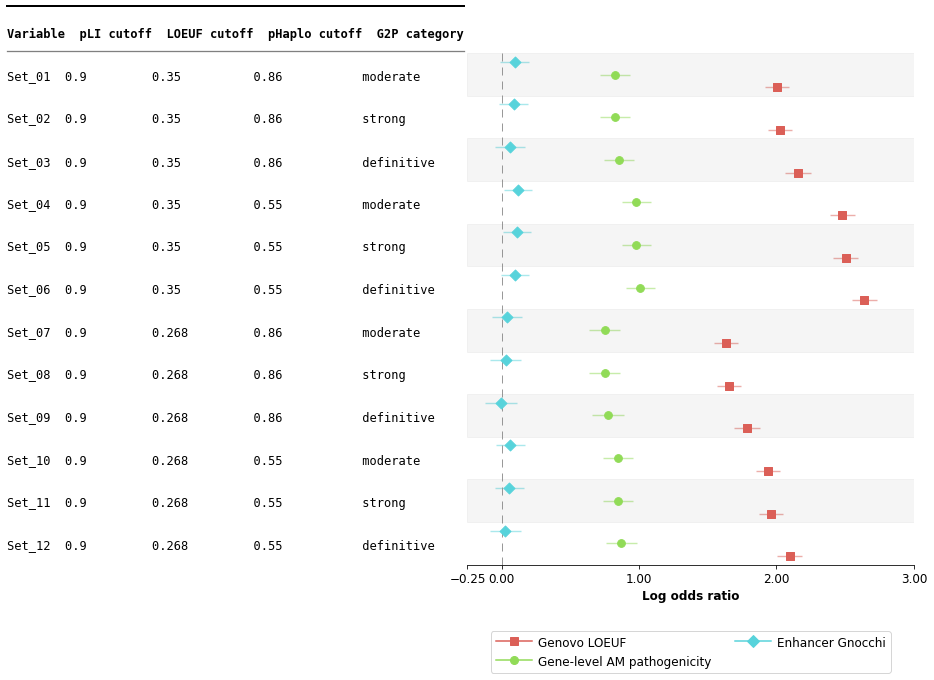

In [199]:
std_opts = dict(
    estimate = "Odds ratio",
    ll = "CI_lower", hl = "CI_upper", 
    varlabel = "Set", 
    capitalize = "capitalize",
    table = True,
    # rightannote=['Model'],
    # right_annoteheaders=['Set name'],
    xlabel = "Log odds ratio",  # x-label title
    ylabel = "log odds ratio",  # y-label title
    annote = ['pLI', 'oe_lof_upper', 'pHaplo', 'DECIPHER_definitive'],
    annoteheaders = ['pLI cutoff', 'LOEUF cutoff', 'pHaplo cutoff', 'G2P category'],
    figsize = (8, 10),
    return_df = False,
    markersize = 60,
    offset = 0.3, # override default vertical offset between models (0.0 to 1.0)
    xlinestyle = (0, (8, 6)),  # long dash for x-reference line
    xlinecolor = ".6",  # gray color for x-reference line
    xtick_size = 12,
    color_alt_rows=True,
)



fp_all = fp.mforestplot(
    dataframe = fpdf,
    xticks = [-0.25, 0, 1, 2, 3],
    **std_opts,
    logscale=False,
    model_col = "Group",
    mcolor = list(sns.hls_palette(4)),
    )

# fpdf_gnocchi = fpdf[fpdf['Group'] == 'Enhancer Gnocchi']
# fp_gnocchi = fp.mforestplot(
#     dataframe = fpdf_gnocchi,
#     xticks = [-0.25, 0, 0.5, 1, 1.5],
#     **std_opts,
#     logscale=False,
#     model_col = "Group",
#     mcolor = list(sns.hls_palette(4)),
#     )

# fpdf_am = fpdf[fpdf['Group'] == 'Gene-level AM pathogenicity']
# fp_am = fp.mforestplot(
#     dataframe = fpdf_am,
#     xticks = [-0.25, 0, 0.5, 1, 1.5],
#     **std_opts,
#     logscale=False,
#     model_col = "Label",
#     mcolor = list(sns.hls_palette(4)),
#     )

# fpdf_genovo = fpdf[fpdf['Group'] == 'Genovo LOEUF']
# fp_genovo = fp.mforestplot(
#     dataframe = fpdf_genovo,
#     xticks = [-0.25, 1, 2, 3.5],
#     **std_opts,
#     logscale=False,
#     model_col = "Label",
#     mcolor = list(sns.hls_palette(4)),
#     )

In [210]:
final_conditions = conditions_list[3]
final_elofs = create_gene_list(ajhg, alldf, higene, gnomad, *final_conditions)

final_elofs_gene = final_elofs[1]
print(len(final_elofs_gene))
df_final_elofs = pd.DataFrame(final_elofs_gene, columns=['gene'])

# Output final gene list as tsv
df_final_elofs.to_csv(f'final_elofs_{final_conditions[0]}.tsv', sep='\t', index=False)

set_04 AJHG:DCPR:HI:pHaplo:Total - 1043 1880 347 2459 4250
4250
